In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from tqdm.auto import tqdm

## Dataset

High Frequency data of stocks described in https://arxiv.org/pdf/1705.03233.pdf

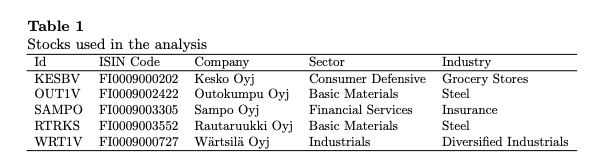

It has 10 days of limit order book data from June 2010 for 5 stocks that traded on the Helsinkin exchange (from Jun 1 to Jun 14)


The total number of messages (e.g., arriving buy/sell/cancel orders) is approximately 4 million.
The dataset includes an orderbook snapshot after every 10 messages resulting in 400000 records in total for 5 stocks.
On average, there is one snapshot for approximately every one-half second.

Remark: The dataset includes events only from 10:30 to 18:00 trading time (i.e., excludes the Auction period before 10:00 and post-opening period between 18:25 and 18:30) because of different rules enforced during those periods.

In [4]:
from pathlib import Path

DATA_DIR = Path("../data/FI2010")

In [5]:
ls {DATA_DIR}

73eb48d7-4dbc-4a10-a52a-da745b47a649_hfcjaa8f.zip
README.md
all_with_anomalies.parquet
processed.parquet
published/


In [5]:
testdirectory = (
    DATA_DIR
    / "published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Testing/"
)
traindirectory = (
    DATA_DIR
    / "published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/"
)
train_files = [
    traindirectory / f"Train_Dst_NoAuction_DecPre_CF_{i+1}.txt" for i in range(9)
]
test_files = [
    testdirectory / f"Test_Dst_NoAuction_DecPre_CF_{i+1}.txt" for i in range(9)
]

In [6]:
dec_data = np.loadtxt(
    DATA_DIR
    / "published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_1.txt"
)

In [7]:
d = pd.read_fwf(train_files[0], header=None)

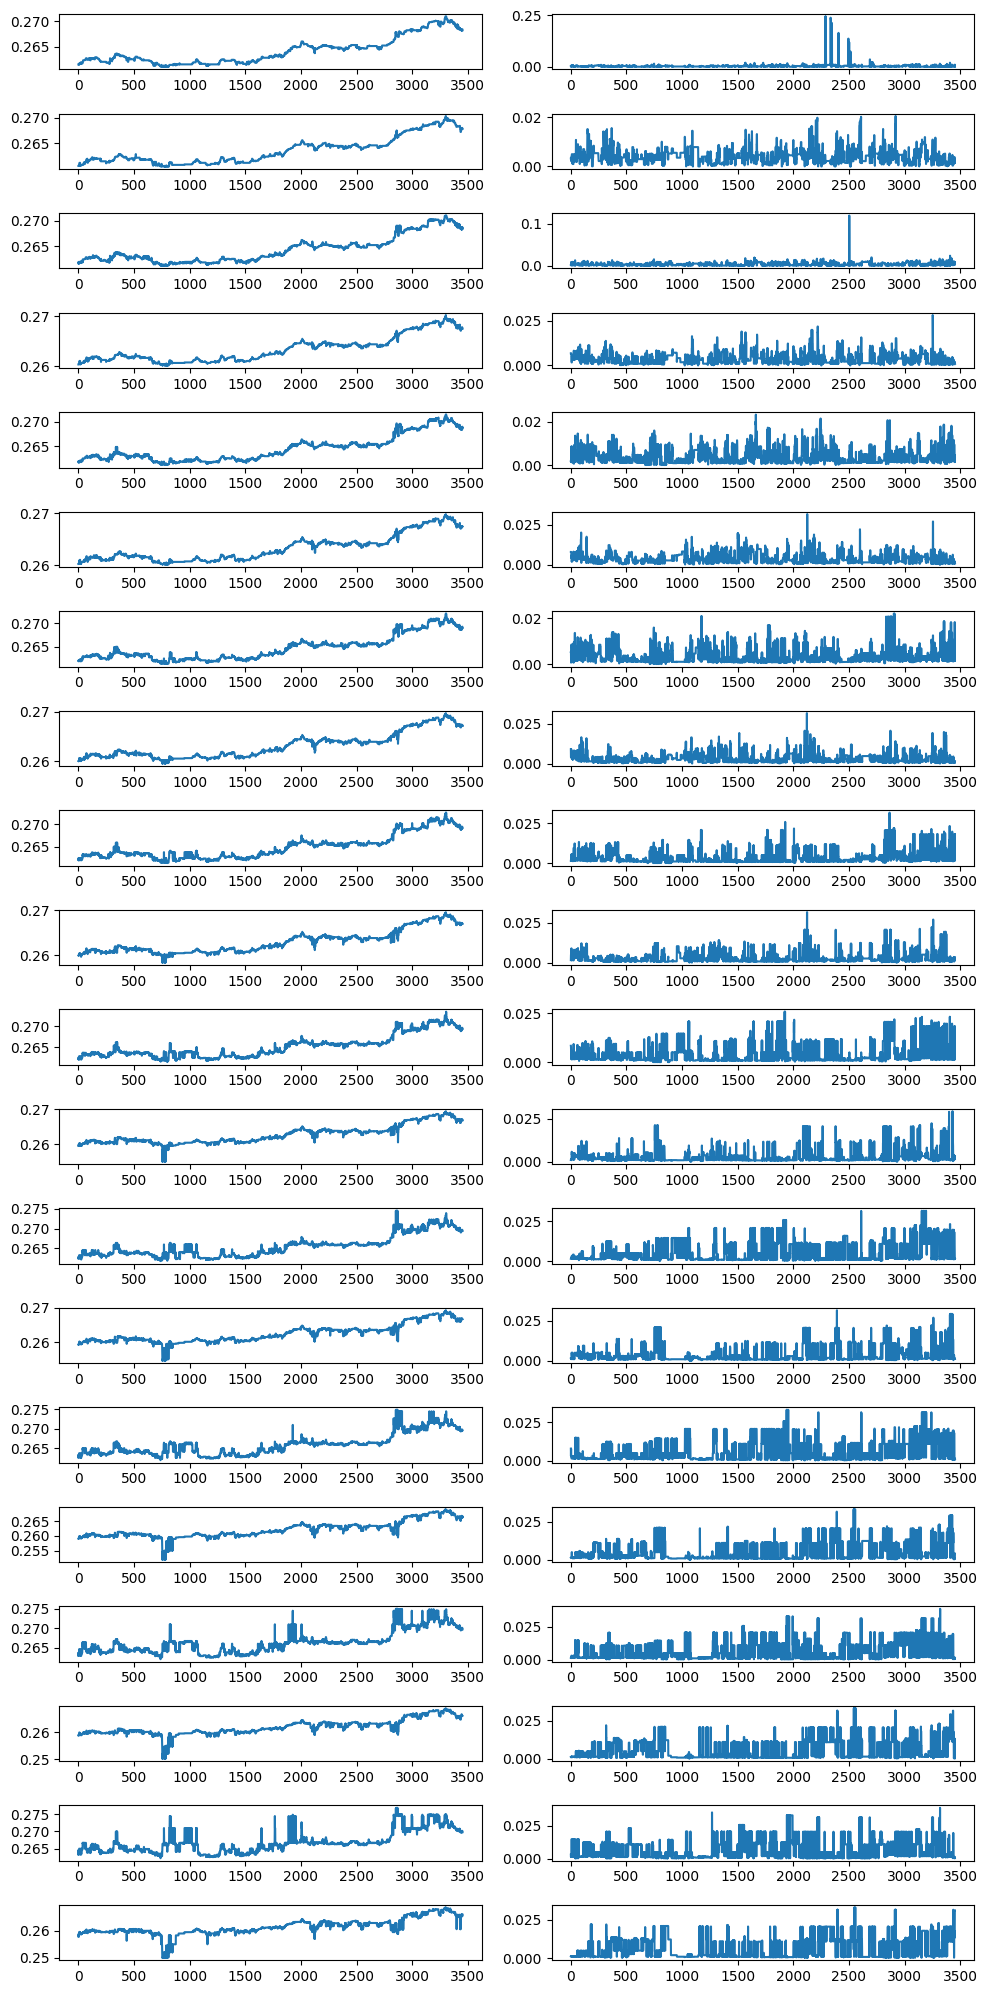

In [8]:
# read first day's data and plot price and volume for first stock
d = pd.read_fwf(train_files[0], header=None)
#  - price/vol
fig = plt.figure(figsize=(10, 20))
for i in range(40):
    plt.subplot(20, 2, i + 1)
    d.iloc[i, :3454].plot()
plt.tight_layout()

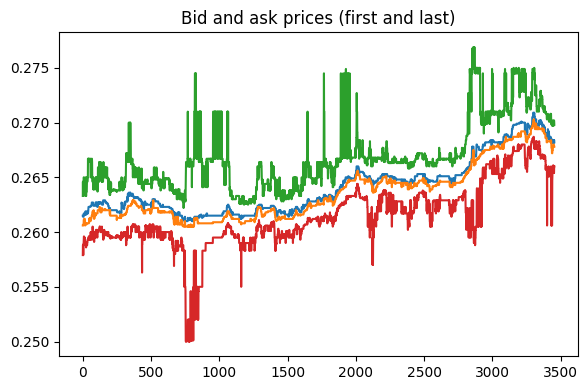

In [13]:
#  Plot inside and outside price bid and offer levels
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
d.iloc[0, :3454].plot()
d.iloc[2, :3454].plot()
d.iloc[36, :3454].plot()
d.iloc[38, :3454].plot()
plt.title("Bid and ask prices (first and last)")
plt.tight_layout();

We are only interested in the mid price

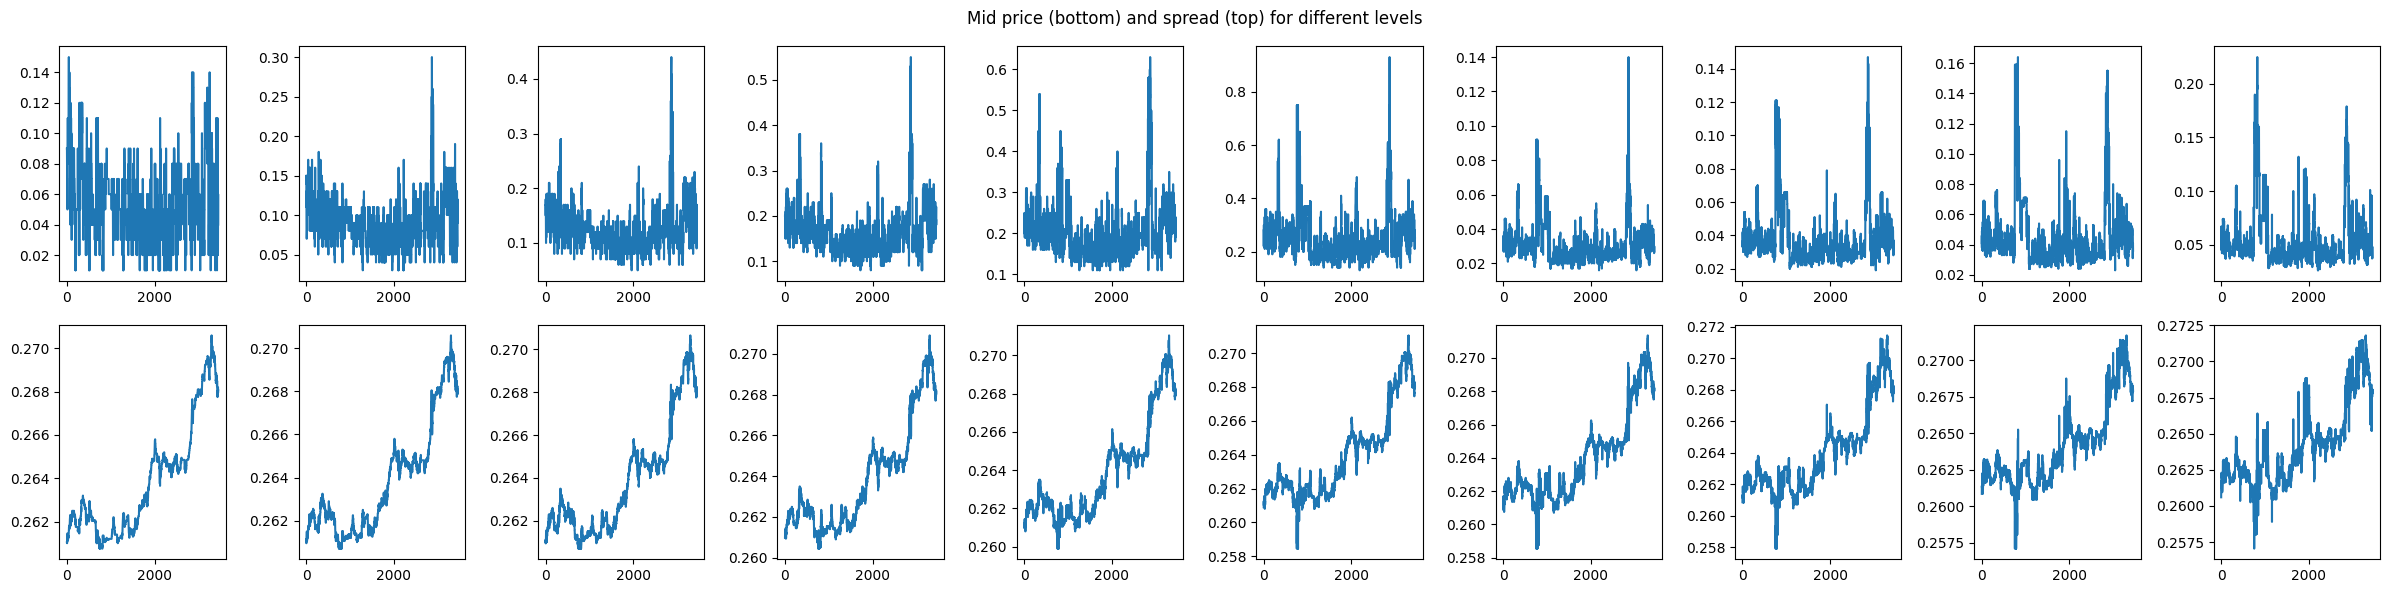

In [27]:
# v2 - spread and mid (41-60)
fig, axs = plt.subplots(2, 10, figsize=(24, 6))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    d.iloc[i + 40, :3454].plot()
fig.suptitle("Mid price (bottom) and spread (top) for different levels")
plt.tight_layout()

In [29]:
# lets just take the mid price at first bid/ask time series
d.iloc[10 + 40, :3454]

0       0.26105
1       0.26105
2       0.26100
3       0.26100
4       0.26100
         ...   
3449    0.26820
3450    0.26805
3451    0.26810
3452    0.26810
3453    0.26800
Name: 50, Length: 3454, dtype: float64

### Transform dataset to a better format

the dataset is formatted strangely, lets transform it to a more convenient format

In [30]:
def get_info(filename):
    # find the index of the breaks between tickers (b)
    d = np.loadtxt(filename)
    i = np.arange(d.shape[1])
    b = i[np.r_[[True], np.abs(np.diff(d[0])) > 0.01]]
    b = np.append(b, d.shape[1])
    return b, d

In [31]:
all_files = train_files + test_files

In [32]:
dat = []
all_data = []
for i, filename in enumerate(all_files):
    print(filename)
    b, d = get_info(filename)
    dat.append(b)
    all_data.append(d)
    print(b)

../data/FI2010/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_1.txt
[    0  3454  9772 14694 25413 39512]
../data/FI2010/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_2.txt
[    0  8533 20973 31860 49291 77909]
../data/FI2010/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_3.txt
[     0  12436  30287  45201  67818 106444]
../data/FI2010/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_4.txt
[     0  15242  40085  60341  93777 143467]
../data/FI2010/published/BenchmarkDatasets/BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_5.txt
[     0  18272  49843  76045 115859 178252]
../data/FI2010/published/Benchma

In [33]:
all_data[0].shape

(149, 39512)

In [ ]:
# lens = [d.shape[1] for d in all_data]
# lens = np.array(lens)

In [34]:
len(all_data)

18

In [71]:
all_dfs = []
for day, (np_arr, b) in enumerate(zip(all_data, dat)):
    df = pd.DataFrame(np_arr).T
    df["stock"] = np.nan
    for i in range(1, len(b)):
        df.iloc[b[i - 1] : b[i], -1] = i
    train = 1
    if day >= 9:
        day -= 9
        train = 0
    df["day"] = day
    df["train"] = train
    all_dfs.append(df)

In [85]:
all = pd.concat(all_dfs)
all.reset_index(drop=True, inplace=True)
all["stock"] = all["stock"].astype(np.int32)
all["day"] = all["day"].astype(np.int32)
all["train"] = all["train"].astype(np.int16)

In [86]:
all.to_parquet(DATA_DIR / "processed.parquet")

/Users/th/Documents/icl_thesis/env/lib/python3.10/site-packages/pandas/io/parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [87]:
ls {DATA_DIR}

73eb48d7-4dbc-4a10-a52a-da745b47a649_hfcjaa8f.zip
processed.parquet
published/


In [6]:
df = pd.read_parquet(DATA_DIR / "processed.parquet")

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,stock,day,train
0,0.2615,0.00353,0.2606,0.00326,0.2618,0.00200,0.2604,0.00682,0.2619,0.00164,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1,0,1
1,0.2615,0.00211,0.2606,0.00326,0.2619,0.00164,0.2604,0.00682,0.2620,0.00138,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1,0,1
2,0.2614,0.00122,0.2606,0.00326,0.2615,0.00200,0.2604,0.00682,0.2617,0.00361,...,0.0,0.0,3.0,3.0,2.0,2.0,2.0,1,0,1
3,0.2614,0.00322,0.2606,0.00326,0.2617,0.00938,0.2604,0.00682,0.2619,0.00850,...,0.0,0.0,2.0,2.0,3.0,2.0,2.0,1,0,1
4,0.2614,0.00322,0.2606,0.00326,0.2617,0.00938,0.2604,0.00682,0.2619,0.00850,...,0.0,0.0,1.0,1.0,1.0,2.0,2.0,1,0,1


In [8]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,stock,day,train
2045186,0.3783,0.01131,0.3782,0.00877,0.3784,0.00775,0.3778,0.00413,0.3785,0.022,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5,8,0
2045187,0.3783,0.01131,0.3782,0.00877,0.3784,0.00775,0.3778,0.00313,0.3785,0.022,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5,8,0
2045188,0.3783,0.01131,0.3782,0.00877,0.3784,0.00775,0.3778,0.00213,0.3785,0.022,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5,8,0
2045189,0.3783,0.01131,0.3782,0.00877,0.3784,0.00775,0.3779,0.00100,0.3785,0.022,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5,8,0
2045190,0.3783,0.01131,0.3782,0.00877,0.3784,0.00775,0.3778,0.00213,0.3785,0.022,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,5,8,0


visually check if the aggregated frames make sense

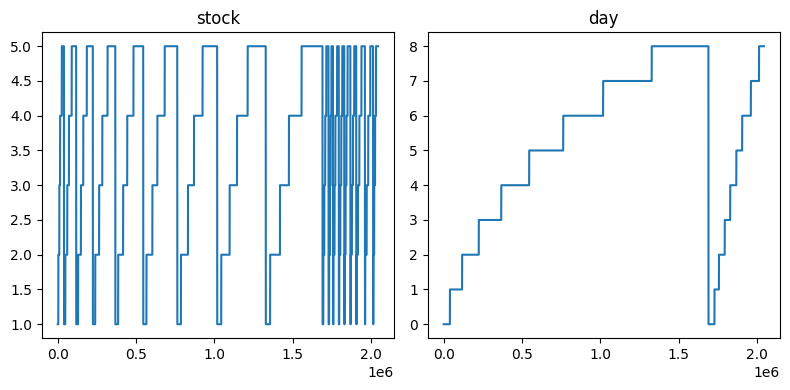

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
df.stock.plot(title="stock")
plt.subplot(1, 2, 2)
df.day.plot(title="day")
plt.tight_layout();

## Outliers

We employ approach similar to https://arxiv.org/pdf/2209.11686.pdf for synthetic anomalies

but instead of uniform distribution, take normal with the same mean and standard deviation

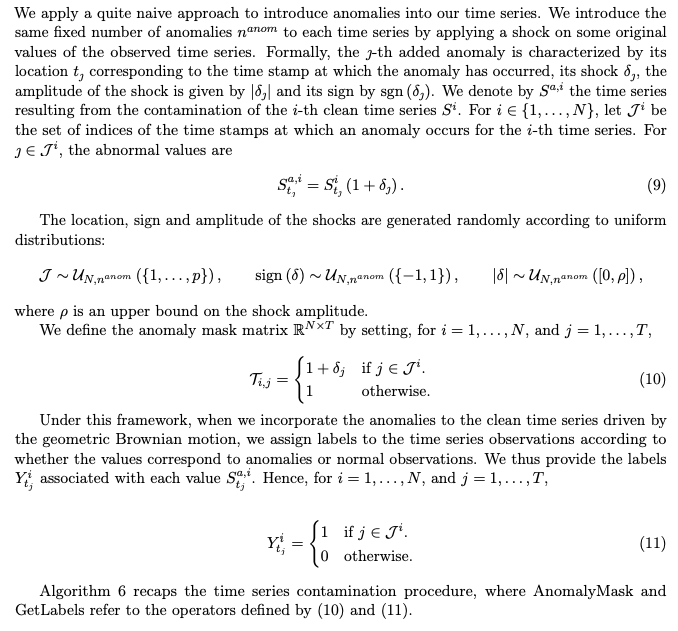

In [10]:
df = pd.read_parquet(DATA_DIR / "processed.parquet")
# take mid price, stock and day and train/test
df = df.loc[:, ["50", "stock", "day", "train"]]
df["mid"] = df.iloc[:, 0]
df.drop(columns=["50"], inplace=True)

In [11]:
d = df.query("stock==1 & day==0 & train==1")

In [12]:
d.head()

,stock,day,train,mid
0,1,0,1,0.26105
1,1,0,1,0.26105
2,1,0,1,0.26100
3,1,0,1,0.26100
4,1,0,1,0.26100


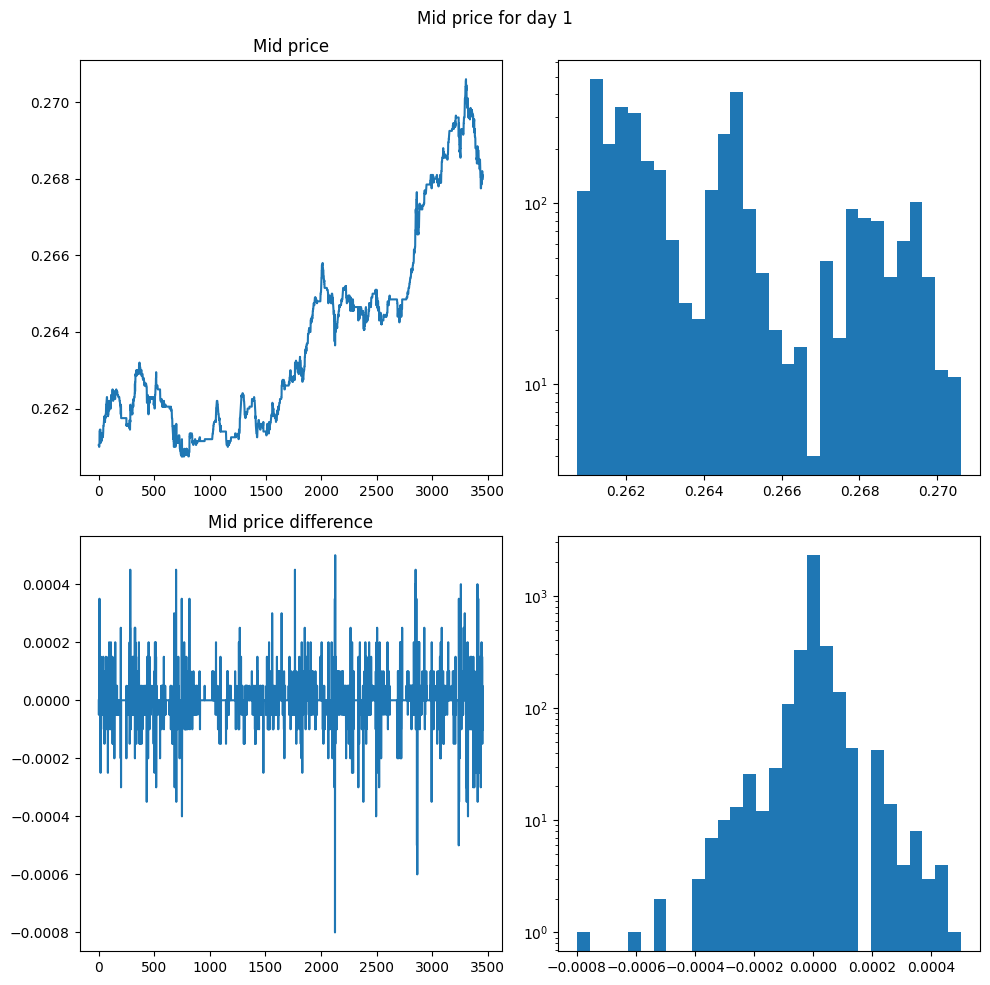

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Mid price for day 1")
plt.subplot(2, 2, 1)
plt.plot(d.mid)
plt.title("Mid price")
plt.subplot(2, 2, 2)
plt.hist(d.mid, bins=30)
plt.yscale("log")
plt.subplot(2, 2, 3)
plt.plot(d.mid.diff())
plt.title("Mid price difference")
plt.subplot(2, 2, 4)
plt.hist(d.mid.diff(), bins=30)
plt.yscale("log")
plt.tight_layout();

### contaminate the time series

In [14]:
d = df.query("stock==1 & day==0 & train==1")
x = d.mid.to_numpy().copy()

In [15]:
np.random.seed(1)

prop_outliers = 0.01

first = x[0]
rets = x[1:] / x[:-1] - 1
r = np.r_[first, first * np.cumprod(rets + 1)]

assert np.isclose(r, x).all()

outliers_pos = np.random.choice(len(rets), size=int(len(rets) * prop_outliers))
rets_outliers = np.random.uniform(
    size=outliers_pos.shape[0], low=rets.min() / 10, high=rets.max() / 10
)

rets[outliers_pos] += rets_outliers

r = np.r_[first, first * np.cumprod(rets + 1)]

outliers_pos += 1  # in the original time series

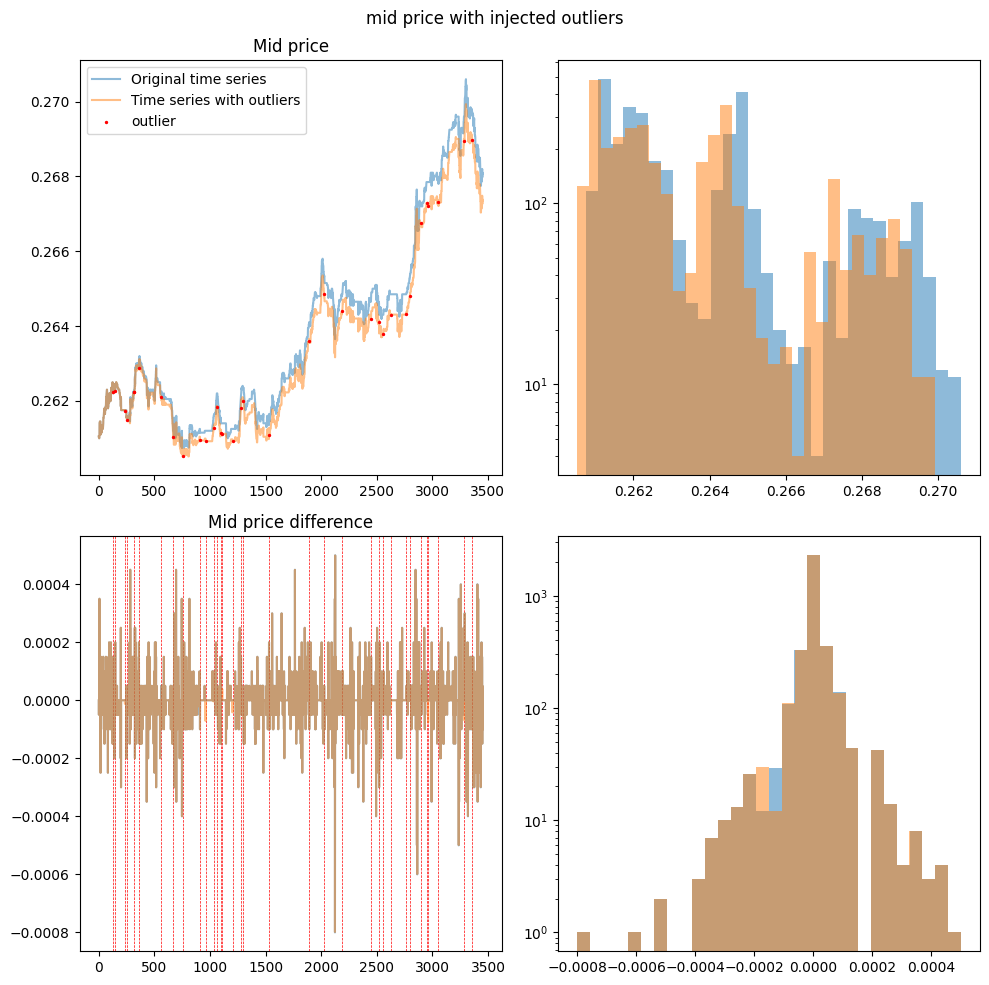

In [16]:
# # visually check
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("mid price with injected outliers")
plt.subplot(2, 2, 1)
plt.plot(x, label="Original time series", zorder=0, alpha=0.5)
plt.plot(r, label="Time series with outliers", zorder=0, alpha=0.5)
for outlier_pos in outliers_pos:
    plt.scatter(outlier_pos, r[outlier_pos], color="red", s=2, zorder=1)
# for legend
plt.scatter(outlier_pos, r[outlier_pos], color="red", s=2, label="outlier", zorder=1)
plt.legend()
plt.title("Mid price")
plt.subplot(2, 2, 2)
plt.hist(x, bins=30, alpha=0.5)
plt.hist(r, bins=30, alpha=0.5)
plt.yscale("log")
plt.subplot(2, 2, 3)
plt.plot(np.diff(x), alpha=0.5)
plt.plot(np.diff(r), alpha=0.5)
for outlier_pos in outliers_pos:
    plt.axvline(outlier_pos, color="red", lw=0.5, ls="--", zorder=1)
plt.title("Mid price difference")
plt.subplot(2, 2, 4)
plt.hist(np.diff(x), bins=30, alpha=0.5)
plt.hist(np.diff(r), bins=30, alpha=0.5)
plt.yscale("log")

plt.tight_layout()
# pd.Series(r - x).hist(bins=40);

the time series (and the diffs) look very close, the method looks fine!

In [17]:
def get_outliers(g, prop_outliers=0.01):
    x = g["mid"].to_numpy().copy()
    first = x[0]
    rets = x[1:] / x[:-1] - 1
    r = np.r_[first, first * np.cumprod(rets + 1)]

    assert np.isclose(r, x).all()

    outliers_pos = np.random.choice(len(rets), size=int(len(rets) * prop_outliers))

    # lq = np.abs(np.quantile(x, 0.1)/10)
    # hq = np.abs(np.quantile(x, 0.9)/10)
    # v = max(lq, hq)
    # low = -v
    # high = v
    # print(low, high)
    # rets_outliers = np.random.uniform(size=outliers_pos.shape[0], low=low, high=high)
    rets_outliers = np.random.normal(
        size=outliers_pos.shape[0], loc=rets.mean(), scale=rets.std()
    )

    rets[outliers_pos] += rets_outliers

    r = np.r_[first, first * np.cumprod(rets + 1)]

    outliers_pos += 1  # in the original time series

    g["outlier"] = 0
    g.iloc[outliers_pos, -1] = 1

    # transformed mid price
    g["tf_mid"] = r
    return g

In [18]:
np.random.seed(1)
prop_outliers = 0.01

all_w_out = []
for desc, g in df.groupby(["stock", "day", "train"]):
    g = g.copy()
    g = get_outliers(g, prop_outliers=prop_outliers)
    all_w_out.append(g)
all_w_out = pd.concat(all_w_out)
all_w_out.reset_index(drop=True, inplace=True)

In [19]:
def plot_outliers(g, desc="", save=True):
    x = g["mid"].to_numpy()
    r = g["tf_mid"].to_numpy()
    outliers_pos = np.where(g["outlier"].to_numpy())[0]
    # # visually check
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(f"{desc}")
    plt.subplot(2, 2, 1)
    plt.plot(x, label="Original time series", zorder=0, alpha=0.5)
    plt.plot(r, label="Time series with outliers", zorder=0, alpha=0.5)
    for outlier_pos in outliers_pos:
        plt.scatter(outlier_pos, r[outlier_pos], color="red", s=2, zorder=1)
    # for legend
    plt.scatter(
        outlier_pos, r[outlier_pos], color="red", s=2, label="outlier", zorder=1
    )
    plt.legend()
    plt.title("Mid price")
    plt.subplot(2, 2, 2)
    plt.hist(x, bins=30, alpha=0.5)
    plt.hist(r, bins=30, alpha=0.5)
    plt.yscale("log")
    plt.subplot(2, 2, 3)
    plt.plot(np.diff(x), alpha=0.5)
    plt.plot(np.diff(r), alpha=0.5)
    for outlier_pos in outliers_pos:
        plt.axvline(outlier_pos, color="red", lw=0.25, ls="--", zorder=1)
    plt.title("Mid price difference")
    plt.subplot(2, 2, 4)
    plt.hist(np.diff(x), bins=30, alpha=0.5)
    plt.hist(np.diff(r), bins=30, alpha=0.5)
    plt.yscale("log")

    plt.tight_layout()
    plt.plot()
    if save:
        plt.savefig(f"images/tf_mid_{desc}.png")
        plt.close()
    else:
        plt.show()

In [20]:
for desc, g in tqdm(all_w_out.groupby(["stock", "day", "train"])):
    g = g.copy()
    plot_outliers(g, desc)

  0%|          | 0/90 [00:00<?, ?it/s]

### save to parquet

In [21]:
all_w_out.to_parquet(DATA_DIR / "all_with_anomalies.parquet")

In [22]:
all_w_out = pd.read_parquet(DATA_DIR / "all_with_anomalies.parquet")

In [23]:
all_w_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2045191 entries, 0 to 2045190
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   stock    int32  
 1   day      int32  
 2   train    int16  
 3   mid      float64
 4   outlier  int64  
 5   tf_mid   float64
dtypes: float64(2), int16(1), int32(2), int64(1)
memory usage: 66.3 MB


# Plots

In [26]:
df = pd.read_parquet(DATA_DIR / "all_with_anomalies.parquet")
g = df.query("stock==1 & day==0 & train==1")

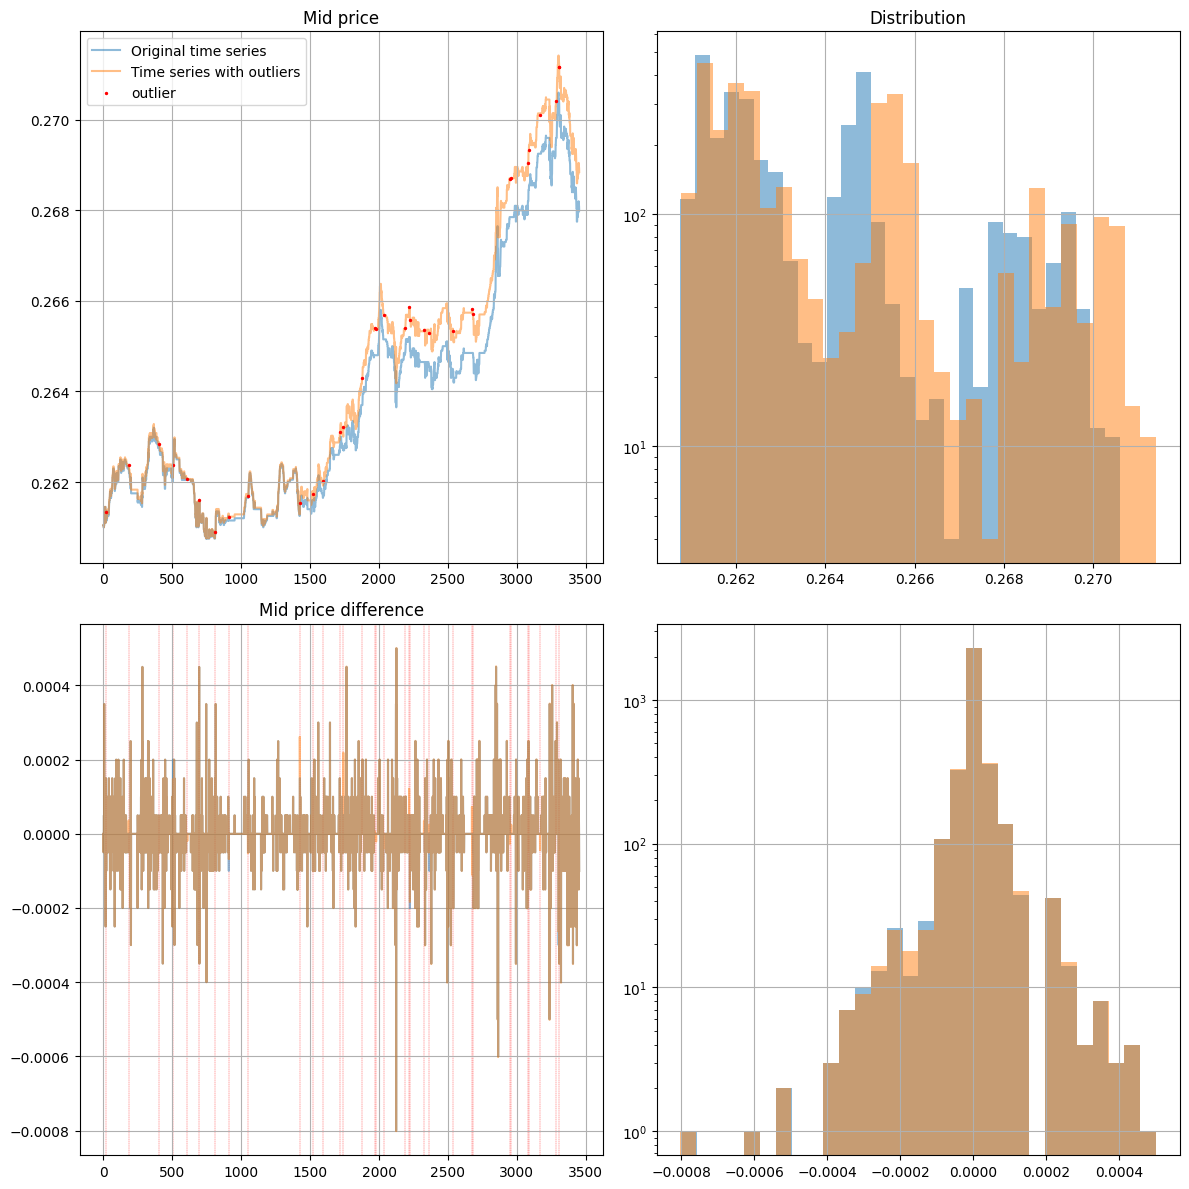

In [35]:
x = g["mid"].to_numpy()
r = g["tf_mid"].to_numpy()
outliers_pos = np.where(g["outlier"].to_numpy())[0]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle(f'Mid price with injected outliers')
plt.subplot(2, 2, 1)
plt.plot(x, label="Original time series", zorder=0, alpha=0.5)
plt.plot(r, label="Time series with outliers", zorder=0, alpha=0.5)
for outlier_pos in outliers_pos:
    plt.scatter(outlier_pos, r[outlier_pos], color="red", s=2, zorder=1)
# for legend
plt.scatter(outlier_pos, r[outlier_pos], color="red", s=2, label="outlier", zorder=1)
plt.legend()
plt.title("Mid price")
plt.grid(visible=True)
plt.subplot(2, 2, 2)
plt.hist(x, bins=30, alpha=0.5)
plt.hist(r, bins=30, alpha=0.5)
plt.yscale("log")
plt.title("Distribution")
plt.grid(visible=True)
plt.subplot(2, 2, 3)
plt.plot(np.diff(x), alpha=0.5)
plt.plot(np.diff(r), alpha=0.5)
for outlier_pos in outliers_pos:
    plt.axvline(outlier_pos, color="red", lw=0.25, ls="--", zorder=1)
plt.title("Mid price difference")
plt.grid(visible=True)
plt.subplot(2, 2, 4)
plt.hist(np.diff(x), bins=30, alpha=0.5)
plt.hist(np.diff(r), bins=30, alpha=0.5)
plt.yscale("log")
plt.grid(visible=True)

plt.tight_layout()
plt.plot()
plt.savefig(f"../tex/Figures/FI2010_example_outliers_injected.png")